<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_gaussian_mixture_prior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://arxiv.org/abs/1606.05908

http://ruishu.io/2016/12/25/gmvae/

In [3]:
from sklearn.cluster import KMeans
from sklearn import metrics

#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('dark_background')

import pandas as pd

Using TensorFlow backend.


In [54]:
from sklearn.datasets.samples_generator import make_blobs
X, Y = make_blobs(n_samples=500, centers=5, n_features=50,
                  random_state=0)
print(X.shape)

(500, 50)


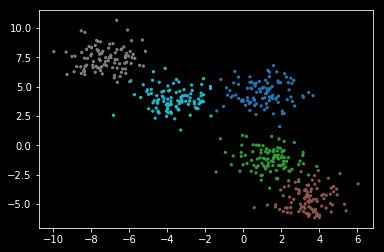

In [55]:
plt.scatter(X[:,0], X[:,1], c=Y, s=5.0, cmap='tab10');

# Gaussian Mixture Prior parameters

Mixture prior with free parameters to be learnt:

https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/vae.py

In [0]:
def z_given(latent_size, mixture_components):
  if mixture_components == 1:
    return tfd.MultivariateNormalDiag(
        loc=tf.zeros([latent_size]),
        scale_identity_multiplier=1.0)

  loc = tf.compat.v1.get_variable(
      name="loc", shape=[mixture_components, latent_size])
  raw_scale_diag = tf.compat.v1.get_variable(
      name="raw_scale_diag", shape=[mixture_components, latent_size])
  mixture_logits = tf.compat.v1.get_variable(
      name="mixture_logits", shape=[mixture_components])

  return tfd.MixtureSameFamily(
      components_distribution=tfd.MultivariateNormalDiag(
          loc=loc,
          scale_diag=tf.nn.softplus(raw_scale_diag)),
      mixture_distribution=tfd.Categorical(logits=mixture_logits),
      name="prior"), loc, mixture_logits

def z_given_x(x, latent_size, reg):
    act = tf.nn.leaky_relu
    h = x
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    loc = tf.layers.dense(h,latent_size)
    log_variance = tf.layers.dense(h, latent_size)
    scale = tf.nn.softplus(log_variance)
    #scale = 1.0*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)


def x_given_z(z, output_size, reg):
    act = tf.nn.leaky_relu
    h = z
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 64, act, kernel_regularizer=reg)
    loc = tf.layers.dense(h, output_size)
    log_variance = tf.layers.dense(h, output_size)
    #scale = tf.nn.softplus(log_variance)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

In [0]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x')
reg = regularizers.l1_l2(l1=0.0, l2=1e-7)
latent_size = 2
k = 5

latent_prior, loc, mixture_logits = z_given(latent_size=latent_size, mixture_components=k)
latent_posterior = z_given_x(x, latent_size, reg)

latent_sampled = latent_posterior.sample()
latent_mean = latent_posterior.mean()

posterior = x_given_z(latent_sampled, X.shape[1], reg)

posterior_sampled = posterior.sample()
posterior_mean = posterior.mean()

rec_loss = tf.losses.mean_squared_error(x, posterior_mean)
kl = tf.reduce_mean(latent_posterior.log_prob(latent_sampled)- latent_prior.log_prob(latent_sampled)) #approximate KL
beta=1.0
kl_loss = beta*kl
reg_loss = tf.losses.get_regularization_loss()
loss = rec_loss + kl_loss + reg_loss

optimizer = tf.train.AdamOptimizer(0.001)
train_op = optimizer.minimize(loss)

In [0]:
#Helper function
def batch_generator(features, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:]

<Figure size 432x288 with 0 Axes>

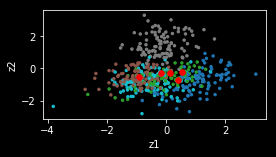

epoch: 1, rec_loss: 32.6216, kl_loss: 2.2470, reg_loss: 0.0000


<Figure size 432x288 with 0 Axes>

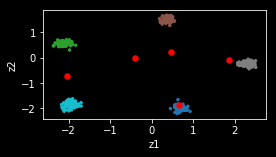

epoch: 100, rec_loss: 1.6437, kl_loss: 2.6001, reg_loss: 0.0000


<Figure size 432x288 with 0 Axes>

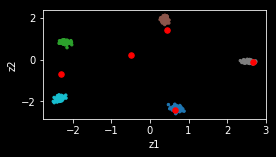

epoch: 200, rec_loss: 1.2575, kl_loss: 2.2104, reg_loss: 0.0000


<Figure size 432x288 with 0 Axes>

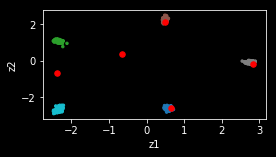

epoch: 300, rec_loss: 1.1194, kl_loss: 2.0126, reg_loss: 0.0000


<Figure size 432x288 with 0 Axes>

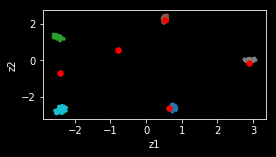

epoch: 400, rec_loss: 1.0680, kl_loss: 1.9895, reg_loss: 0.0000


<Figure size 432x288 with 0 Axes>

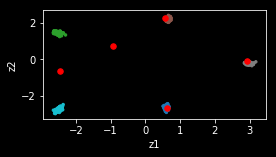

epoch: 500, rec_loss: 1.2048, kl_loss: 1.9375, reg_loss: 0.0000


In [60]:
n_epochs = 500
batch_size = 32
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(n_epochs):
    gen = batch_generator(X, batch_size) #create batch generator
    for j in range(np.int(X.shape[0]/batch_size)):
      x_batch = gen.__next__()
      _ = sess.run(train_op, feed_dict={x: x_batch})
    if (i+1)% 100 == 0 or i == 0:
      latent_mean_, posterior_mean_, rec_loss_, kl_loss_, reg_loss_, loc_= sess.run([latent_mean, posterior_mean, rec_loss, kl_loss, reg_loss, loc], feed_dict ={x:X})
      
      plt.figure(1);
      plt.figure(figsize=(4,2));
      plt.scatter(latent_mean_[:,0],latent_mean_[:,1], c=Y, s=6.0, cmap='tab10');
      plt.scatter(loc_[:,0], loc_[:,1], s=30.0, c='red')
      plt.xlabel('z1');
      plt.ylabel('z2');
      plt.show();
      
      print('epoch: {0}, rec_loss: {1:.4f}, kl_loss: {2:.4f}, reg_loss: {3:.4f}'.format((i+1), rec_loss_, kl_loss_, reg_loss_) )

# Gaussian Mixture Prior full model

ELBO = sum_x sum_y sum_z [log p(x, y, z) -log q(z|x,y)]
     
     = sum_x sum_y sum_z [log p(y)p(z|y)p(x|y,z) -log q(y|x)q(z|x,y)]

In [0]:
def y_given(k):
  probs = tf.nn.softmax(tf.ones(k))
  return tfd.Categorical(probs=probs)

def y_given_x(x, k, reg): #+
    act = tf.nn.leaky_relu
    h = x
    
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    h = tf.layers.dense(h, 32, act, kernel_regularizer=reg)
    
    loc = tf.layers.dense(h, k)
    probs = tf.nn.softmax(loc, axis=-1)
    return tfd.Categorical(probs=probs), probs
  
def z_given_x_y(x, y, latent_size, reg, reuse):
  with tf.variable_scope('z_given_x_y', reuse=reuse):
      act = tf.nn.leaky_relu

      h = tf.concat((x,y), axis=-1)
      h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
      h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
      h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)

      loc = tf.layers.dense(h,latent_size)
      log_variance = tf.layers.dense(h, latent_size)
      scale = tf.nn.softplus(log_variance)
      #scale = 1.0*tf.ones(tf.shape(loc))
      return tfd.MultivariateNormalDiag(loc, scale)

#KL term for w
def z_given_y(y, latent_size, reg, reuse):
  with tf.variable_scope('z_given_y', reuse=reuse):
      act = tf.nn.leaky_relu
      h = y

      loc = tf.layers.dense(h,latent_size)
      log_variance = tf.layers.dense(h, latent_size)
      #scale = tf.nn.softplus(log_variance)
      scale = 0.1*tf.ones(tf.shape(loc))
      return tfd.MultivariateNormalDiag(loc, scale)


def x_given_y_z(y, z, output_size, reg, reuse):
  with tf.variable_scope('x_given_z', reuse=reuse):
      act = tf.nn.leaky_relu

      h = tf.concat((y,z), axis=-1)

      h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)
      h = tf.layers.dense(h, 256, act, kernel_regularizer=reg)

      loc = tf.layers.dense(h, output_size)
      log_variance = tf.layers.dense(h, output_size)
      #scale = tf.nn.softplus(log_variance)
      scale = 0.01*tf.ones(tf.shape(loc))
      return tfd.MultivariateNormalDiag(loc, scale)

In [0]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x')
reg = regularizers.l1_l2(l1=0.0, l2=1e-8)
latent_size = 2
k = 5
reuse = tf.AUTO_REUSE

y_x, y_probs = y_given_x(x, k, reg)
y_prior = y_given(k)


with tf.name_scope('y_'):
    y_ = tf.fill(tf.stack([tf.shape(x)[0], k]), 0.0)

# for each proposed y, infer z and reconstruct x
z_y, z_x_y, x_z = [[None] * k for i in range(3)]
for i in range(k):
    with tf.name_scope('graphs/hot_at{:d}'.format(i)):
        y = tf.add(y_, tf.constant(np.eye(k)[i], name='hot_at_{:d}'.format(i), dtype=tf.float32))
        z_x_y[i] = z_given_x_y(x, y, latent_size, reg, reuse)
        z_y[i] = z_given_y(y, latent_size, reg, reuse)
        x_z[i] = x_given_y_z(y, z_y[i].sample(), X.shape[1], reg, reuse)
        
# Aggressive name scoping for pretty graph visualization :P
with tf.name_scope('loss'):
    losses = [None] * k
    for i in range(k):
        with tf.name_scope('loss_at{:d}'.format(i)):
            losses[i] = 1.0*tfd.kl_divergence(z_x_y[i], z_y[i]) + 1.0*tf.reduce_sum(tf.math.square(x_z[i].mean()-x), axis=-1)
    with tf.name_scope('final_loss'):
        loss1 = tf.add_n([y_probs[:, i] * losses[i] for i in range(k)])

entropy = -1.0*tf.reduce_mean(y_x.entropy())
reg_loss = tf.losses.get_regularization_loss()
kl_y = 200.0*tf.reduce_mean(tfd.kl_divergence(y_x, y_prior))
loss = tf.reduce_mean(loss1)+entropy+kl_y+reg_loss

y_sampled = y_x.sample()
z_mean = z_given_x_y(x, tf.one_hot(y_sampled, k, axis=-1), latent_size, reg, reuse).mean()

optimizer = tf.train.AdamOptimizer(0.001)
train_op = optimizer.minimize(loss)

In [0]:
#Helper function
def batch_generator(features, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:]

<Figure size 432x288 with 0 Axes>

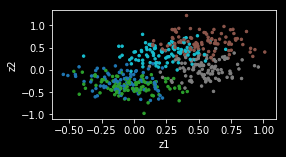

epoch: 1, loss: 1595.8430, rand_score: 0.0749


<Figure size 432x288 with 0 Axes>

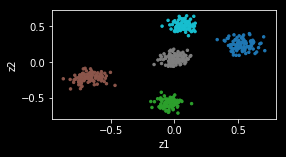

epoch: 10, loss: 379.9305, rand_score: 1.0000


<Figure size 432x288 with 0 Axes>

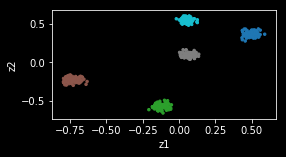

epoch: 20, loss: 372.4672, rand_score: 1.0000


<Figure size 432x288 with 0 Axes>

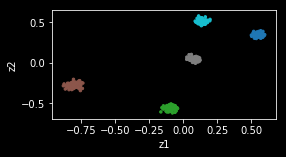

epoch: 30, loss: 371.6561, rand_score: 1.0000


<Figure size 432x288 with 0 Axes>

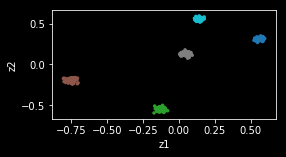

epoch: 40, loss: 371.1739, rand_score: 1.0000


<Figure size 432x288 with 0 Axes>

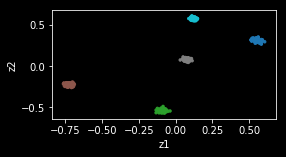

epoch: 50, loss: 370.9378, rand_score: 1.0000


In [64]:
n_epochs = 50
batch_size = 32
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(n_epochs):
    gen = batch_generator(X, batch_size) #create batch generator
    for j in range(np.int(X.shape[0]/batch_size)):
      x_batch = gen.__next__()
      _ = sess.run(train_op, feed_dict={x: x_batch})
    if (i+1)% 10 == 0 or i == 0:
      loss_, y_probs_, z_mean_= sess.run([loss, y_probs, z_mean], feed_dict ={x:X})
      
      plt.figure(1);
      plt.figure(figsize=(4,2));
      plt.scatter(z_mean_[:,0],z_mean_[:,1], c=Y, s=6.0, cmap='tab10');
      plt.xlabel('z1');
      plt.ylabel('z2');
      plt.show();

      print('epoch: {0}, loss: {1:.4f}, rand_score: {2:.4f}'.format((i+1), loss_, metrics.adjusted_rand_score(Y, np.argmax(y_probs_, axis=-1))))